## Stacking Ensemble Model

**TLDR**: Individually, the models LSTM, SVR, and RNN EPAG have the following performance (MAE / MSE):

- LSTM: 0.399 / 0.379
- SRV: 0.375 / 0.288
- RNN EPAG: 0.485 / 0.480

The naive model, i.e. the simple average across all models per timestep, fails to outperform either of the isolated models.  

Expanding on this, a Random Forest Regressor (with and without BF15_1h_lag0 as exogenous variable) has been trained. The results are as follows (MAE / MSE):

- RFR with BF15_1h_lag0: 0.308 / 0.297
- RFR w/out BF15 variables: 0.309 / 0.304

Additionally, a Linear Regression was performed to compare the RFR output. Although it performs better than the individual models, it fails to outperform the Random Forest Classifier:

- Linear Regression with BF15_1h_lag0: 0.329 / 0.278

In [179]:
import pandas as pd
import numpy as np

from models.utility import load_input, scale_with_minmax, get_dates_from_config, handle_outliers, inverse_transform_minmax, split_dataframe
from models.deeplearner import DeepLearner

from solutil import evaluations as ev
from solutil import feature_selection as fs

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid

### Data Import

In [180]:
# CSV Import YPred
df_lstm = pd.read_csv('experiments/stacking_data/ypred_lstm.csv', index_col=0)
df_svr = pd.read_csv('experiments/stacking_data/ypred_svr.csv', index_col=0)
df_bm = pd.read_csv('experiments/stacking_data/ypred_benchmark_4h.csv', index_col=0)

In [181]:
# CSV Import Features
df_features = pd.read_csv('experiments/stacking_data/features_lstm.csv', index_col=0)
df_solofeat = df_features.copy().drop(columns=['temp_1h_lag1', 'glob_1h_lag2', 'glob_1h_lag3',
                                               'rain_1h_lag1', 'schmelz_1h_lag1'])

In [182]:
# Dataframe Stacking & Handling
df_step1 = df_lstm.merge(right=df_svr, how='outer', left_index=True, right_index=True)
df_inlet1 = df_step1.merge(right=df_bm, how='inner', left_index=True, right_index=True)
df_inlet1.drop(columns=['ytest_svr', 'act_inlet1', 'act_inlet2', 'pred_inlet2'], inplace=True)
df_inlet1.dropna(inplace=True)
df_inlet1.rename(columns={'pred_inlet1':'ypred_rnn_inl1'}, inplace=True)

In [183]:
df_inlet1

,ypred_lstm,ytest,ypred_svr,ypred_rnn_inl1
2023-07-07 08:00:00+01:00,0.969592,0.874634,1.083803,1.080630
2023-07-07 12:00:00+01:00,1.154664,1.502004,1.061284,1.278414
2023-07-07 16:00:00+01:00,1.154210,1.119425,1.048482,1.164357
2023-07-07 20:00:00+01:00,1.041266,0.930587,1.156831,1.036615
2023-07-08 00:00:00+01:00,0.980204,0.844650,1.190629,0.762699
...,...,...,...,...
2024-06-27 12:00:00+01:00,4.006455,4.200000,4.588735,3.837116
2024-06-27 16:00:00+01:00,3.966081,4.200000,4.084841,3.786599
2024-06-27 20:00:00+01:00,3.895660,4.200000,3.798774,3.828304
2024-06-28 00:00:00+01:00,3.647906,4.193108,3.932334,3.799263


### Feature Analysis

C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascie

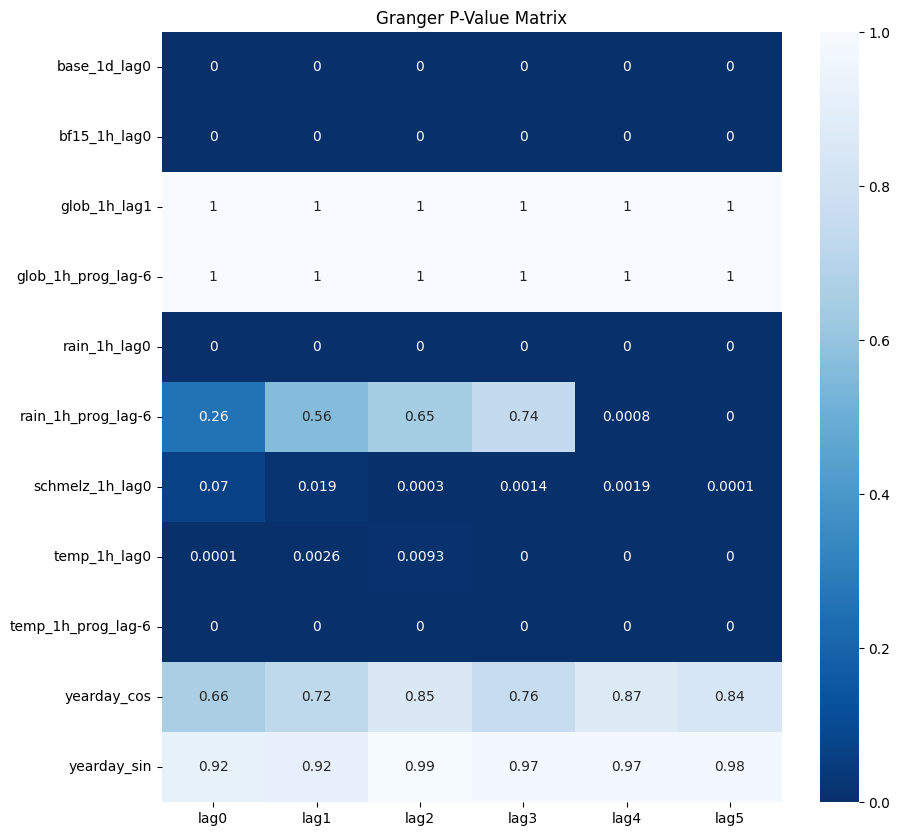

In [184]:
# Calculate Granger Causality Tests
granger = fs.granger_causality_test(df=df_solofeat, target_var='base_lag0', annot=True)

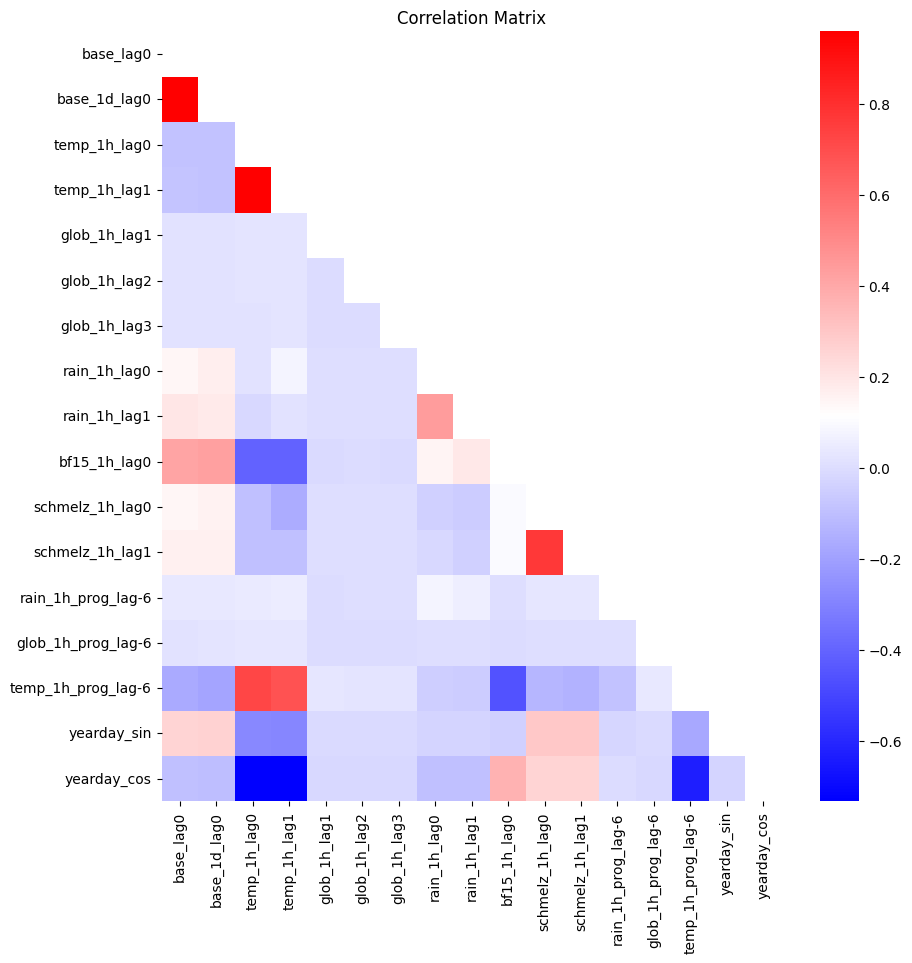

In [185]:
# Calculate Correlogram
corr_matrix = fs.correlation_matrix(df_features, method='pearson')

### Sample Preparation for ML Models

In [186]:
# Add most relevant feature
df_inlet1['bf15_1h_lag0'] = df_features['bf15_1h_lag0']

In [187]:
df_inlet1

,ypred_lstm,ytest,ypred_svr,ypred_rnn_inl1,bf15_1h_lag0
2023-07-07 08:00:00+01:00,0.969592,0.874634,1.083803,1.080630,0.861813
2023-07-07 12:00:00+01:00,1.154664,1.502004,1.061284,1.278414,0.830625
2023-07-07 16:00:00+01:00,1.154210,1.119425,1.048482,1.164357,0.795000
2023-07-07 20:00:00+01:00,1.041266,0.930587,1.156831,1.036615,0.779500
2023-07-08 00:00:00+01:00,0.980204,0.844650,1.190629,0.762699,0.770000
...,...,...,...,...,...
2024-06-27 12:00:00+01:00,4.006455,4.200000,4.588735,3.837116,1.005500
2024-06-27 16:00:00+01:00,3.966081,4.200000,4.084841,3.786599,0.985604
2024-06-27 20:00:00+01:00,3.895660,4.200000,3.798774,3.828304,0.990583
2024-06-28 00:00:00+01:00,3.647906,4.193108,3.932334,3.799263,1.049271


In [188]:
# Min Max Scaling
df_inlet1_scaled = scale_with_minmax(df_features=df_inlet1, str_model='inlet1_ens')

In [189]:
# Split dataframe
x_train, x_test, y_train, y_test = split_dataframe(df_features=df_inlet1_scaled, target_var='ytest')

### Ensemble Model Construction

#### Isolated Predictions

In [190]:
# Get Date Limits for Test Set 
start_date = y_test.index[0]
end_date = y_test.index[-1]

In [191]:
df_inlet_short = df_inlet1.loc[(df_inlet1.index >= start_date) & (df_inlet1.index <= end_date)]

**LSTM**

In [192]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_lstm'])

{'mae': 0.39868943599320966,
 'mse': 0.3789452409375571,
 'rmse': 0.6155852832366585,
 'mape': 36306637691870.766,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

**SVR**

In [193]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_svr'])

{'mae': 0.37535255269991946,
 'mse': 0.2881804957593786,
 'rmse': 0.5368244552545819,
 'mape': 26330720039415.305,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

**RNN EPAG**

In [194]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_rnn_inl1'])

{'mae': 0.48491127379362836,
 'mse': 0.4799655616179281,
 'rmse': 0.692795468820292,
 'mape': 47194900988663.164,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

#### Naive Model

In [195]:
x_test_naive = x_test.drop(columns=['bf15_1h_lag0'])

In [196]:
ypred_naive = x_test_naive.mean(axis=1)

In [197]:
# Rescale predictions
y_pred_naive_rescaled = inverse_transform_minmax(df_scaled=ypred_naive, str_model='inlet1_ens', attributes='ytest')
y_test_rescaled = inverse_transform_minmax(df_scaled=y_test, str_model='inlet1_ens', attributes='ytest')

In [198]:
ev.get_eval_metrics(y_test_rescaled, y_pred_naive_rescaled)

{'mae': 0.5648443342345154,
 'mse': 0.4569093383011825,
 'rmse': 0.6759506922114826,
 'mape': 33384543772765.543,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

#### Random Forest Regressor with BF15_1h_lag0

**Grid Search**

In [199]:
# Instantiate RFR
grid_forest = RandomForestRegressor(n_jobs=-1)

In [200]:
# Define Parameter Grid
hyperparams = {
   'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 8, 16, 32, 64],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 4, 8, 16]
}

param_grid = ParameterGrid(hyperparams)

In [201]:
# Instantiate Grid Search Object
rfr_gridsearch = GridSearchCV(estimator=grid_forest, param_grid=hyperparams, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=3)

In [202]:
rfr_gridsearch.fit(x_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 8, 16, 32, 64],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [203]:
# Output Results
print(f"Best Parameters: {rfr_gridsearch.best_params_}")
print(f"Best Score: {rfr_gridsearch.best_score_}")

Best Parameters: {'max_depth': 32, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
Best Score: -0.012072055849439834


- Best Parameters: {'max_depth': 32, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
- Best Score: -0.012115434320588073

**Random Forest Model**

In [204]:
# Define hyperparameters
best_params = {'max_depth': 32, 
               'min_samples_leaf': 8, 
               'min_samples_split': 8, 
               'n_estimators': 100}

In [205]:
# Parameterize model
forest = RandomForestRegressor(**rfr_gridsearch.best_params_)

In [206]:
# Train model
trained_forest = forest.fit(x_train, y_train)

In [207]:
# Predict inlet1
ypred_rfr = trained_forest.predict(x_test)

In [208]:
# Rescale predictions
y_pred_rfr_rescaled = inverse_transform_minmax(df_scaled=ypred_rfr, str_model='inlet1_ens', attributes='ytest')

<Axes: xlabel='time', ylabel='value'>

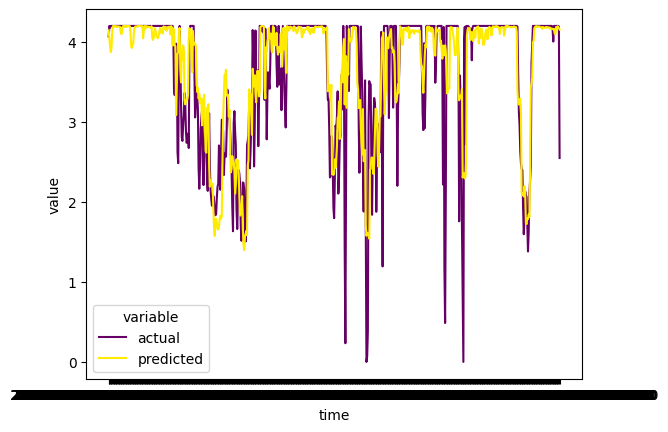

In [209]:
ev.get_act_vs_pred_plot(y_test_rescaled, y_pred_rfr_rescaled)

In [210]:
ev.get_eval_metrics(y_test_rescaled, y_pred_rfr_rescaled)

{'mae': 0.30496623740303885,
 'mse': 0.2899147133330157,
 'rmse': 0.5384372882082143,
 'mape': 27536237809349.6,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

#### Endogenous Random Forest Regressor

In [211]:
# Drop exogenous variables
x_train_pure = x_train.drop(columns=['bf15_1h_lag0'])
x_test_pure = x_test.drop(columns=['bf15_1h_lag0'])

**Grid Search**

In [212]:
# Instantiate Grid Search Object
purerfr_gridsearch = GridSearchCV(estimator=grid_forest, param_grid=hyperparams, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=3)

In [213]:
purerfr_gridsearch.fit(x_train_pure, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 8, 16, 32, 64],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [214]:
# Output Results
print(f"Best Parameters: {purerfr_gridsearch.best_params_}")
print(f"Best Score: {purerfr_gridsearch.best_score_}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 100}
Best Score: -0.011486012805887043


**RFR Model**

In [215]:
# Define hyperparameters
pure_params = {'max_depth': 64, 
               'min_samples_leaf': 8, 
               'min_samples_split': 4, 
               'n_estimators': 200}

In [216]:
# Parameterize model
pure_forest = RandomForestRegressor(**purerfr_gridsearch.best_params_)

In [217]:
# Train model
trained_pureforest = pure_forest.fit(x_train_pure, y_train)

In [218]:
# Predict inlet1
ypred_purerfr = trained_pureforest.predict(x_test_pure)

In [219]:
# Rescale predictions
y_pred_purerfr_rescaled = inverse_transform_minmax(df_scaled=ypred_purerfr, str_model='inlet1_ens', attributes='ytest')

<Axes: xlabel='time', ylabel='value'>

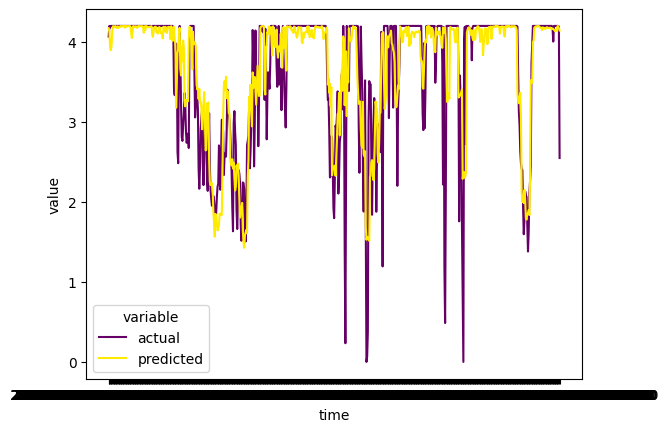

In [220]:
ev.get_act_vs_pred_plot(y_test_rescaled, y_pred_purerfr_rescaled)

In [221]:
ev.get_eval_metrics(y_test_rescaled, y_pred_purerfr_rescaled)

{'mae': 0.3067894517091069,
 'mse': 0.30122625713866785,
 'rmse': 0.5488408304223255,
 'mape': 27071658559438.062,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

#### Linear Regression

In [222]:
linreg = LinearRegression()

In [223]:
trained_reg = linreg.fit(x_train, y_train)

In [224]:
ypred_linreg = trained_reg.predict(x_test)

In [225]:
ypred_linreg_rescaled = inverse_transform_minmax(df_scaled=ypred_linreg, str_model='inlet1_ens', attributes='ytest')

<Axes: xlabel='time', ylabel='value'>

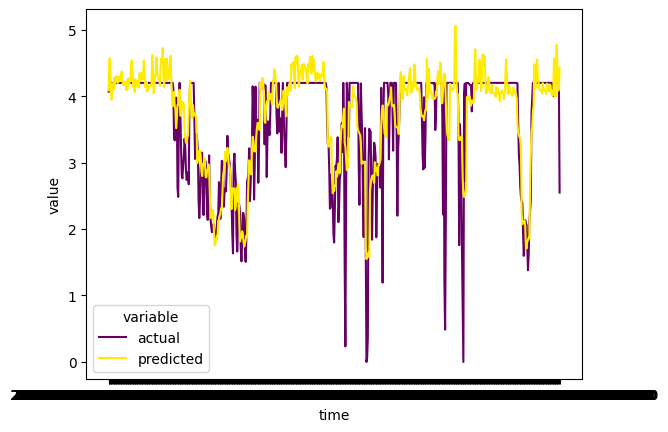

In [226]:
ev.get_act_vs_pred_plot(y_test_rescaled, ypred_linreg_rescaled)

In [227]:
ev.get_eval_metrics(y_test_rescaled, ypred_linreg_rescaled)

{'mae': 0.32878704266929665,
 'mse': 0.27752184551339343,
 'rmse': 0.5268034220782867,
 'mape': 28554673383972.062,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}